# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:05:37.791702
Mem. usage decreased to 1449.68 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7876170,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876171,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876172,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7876173,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Aggregated Data

## Aggregation

In [6]:
df_aggregated = pd.pivot_table(df, values=target_variable, index=['Year','Week','Date','CENSHARE_CAT_1'], aggfunc=np.sum)
df_aggregated.reset_index(level=df_aggregated.index.names, inplace=True)

In [7]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover
0,2015,1,2015W1,Bad,11483.400391
1,2015,1,2015W1,Bett,35661.351562
2,2015,1,2015W1,Elektronik Gadget,636.500000
3,2015,1,2015W1,Heim & Haushalt,1992.900024
4,2015,1,2015W1,Kinder,124.700005
...,...,...,...,...,...
4698,2020,47,2020W47,Outdoor,3029.050049
4699,2020,47,2020W47,Papeterie,52536.050781
4700,2020,47,2020W47,Reisegepack,40673.160156
4701,2020,47,2020W47,Tisch,179621.281250


## Visualize Timeseries

In [8]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of Censhare 1 Categories - category to be vizualized.
            Example: ['Reisegepack', 'Papeterie','Kinder']
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for category in samples:
        df_article = sales.loc[sales.CENSHARE_CAT_1 == category].sort_values(by=['Year', 'Week']).reset_index()

        df_article.plot(x='Date',
                     y=target_variable,
                     title= f'CENSHARE_CAT_1: {category}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

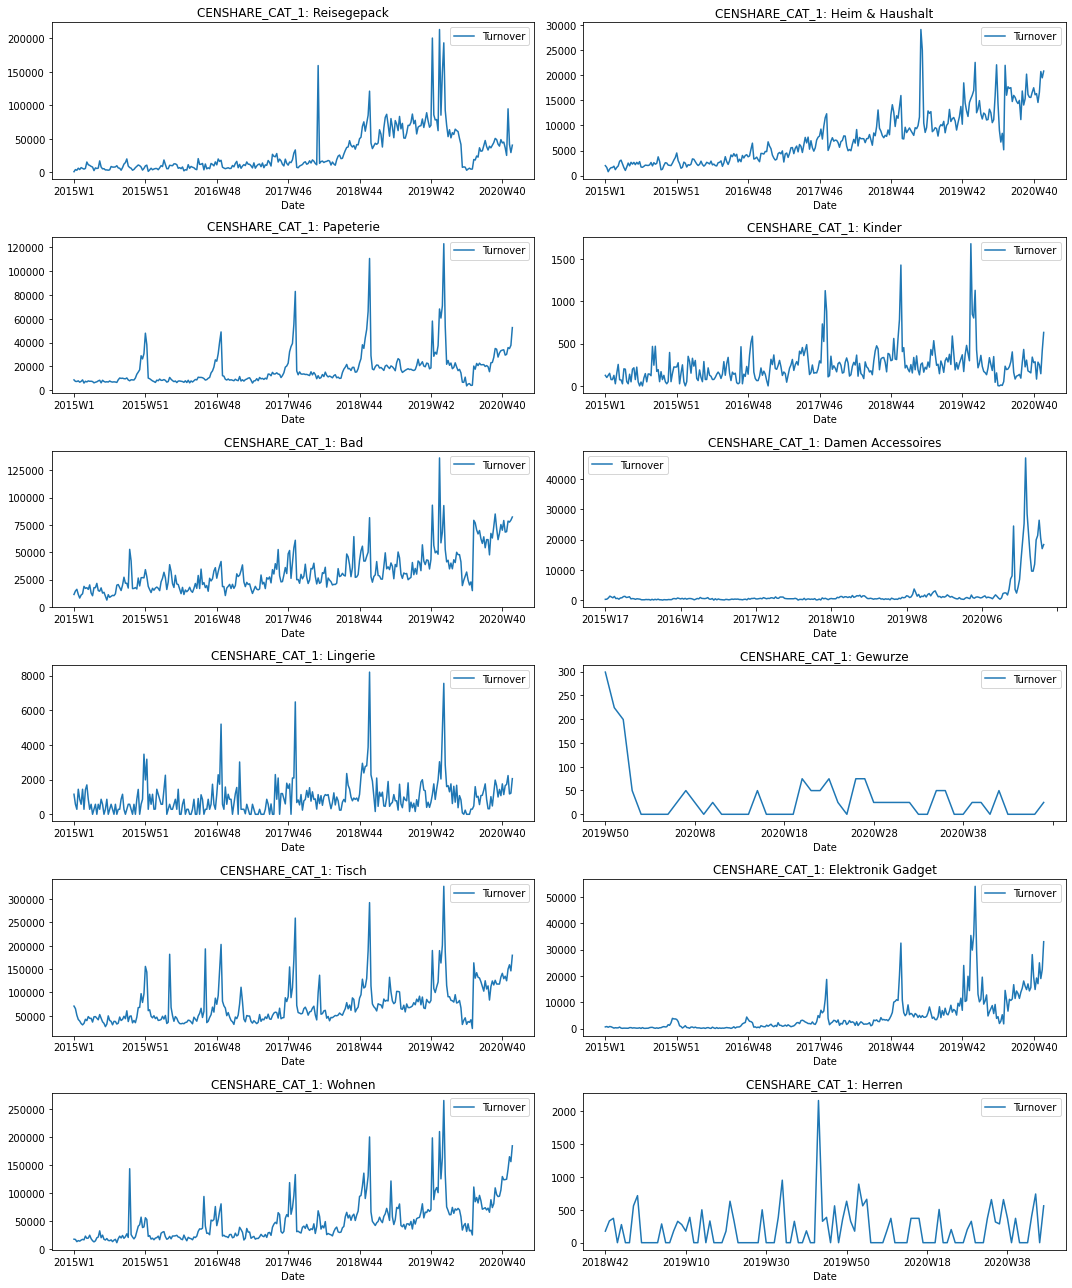

In [9]:
n_series = 12

samples = df_aggregated['CENSHARE_CAT_1'].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

plot_timeseries(samples, df_aggregated)

## Feature Engineering

In [10]:
df_aggregated['rolling_mean_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df_aggregated['rolling_mean_w8'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df_aggregated['lag_w1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1))

df_aggregated['lag_w2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(2))

df_aggregated['lag_w3'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(3))

df_aggregated['lag_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(4))

df_aggregated['lag_y1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(52))

df_aggregated['lag_y2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(104))

## Forecast (LightGBM)

In [11]:
cat_features = [
'Week', 'Year', 'CENSHARE_CAT_1']

num_features = [
'rolling_mean_w4',
       'rolling_mean_w8', 'lag_w1', 'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1',
       'lag_y2'
]

features = cat_features + num_features

In [12]:
# Convert categorical features to integers 
df_aggregated = utils.encode_categorical(df_aggregated, cat_features, downcast_cols=False)

In [13]:
splits = utils.get_splits(df_aggregated, fh=forecast_horizon, n_splits=1)

In [14]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [15]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][features]
    y_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][target_variable]

    x_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][features]
    y_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 5W45 ******
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8047
[LightGBM] [Info] Number of data points in the train set: 4686, number of used features: 11
[LightGBM] [Info] Start training from score 10.129199
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 17592.1	valid_1's rmse: 41898.9
[50]	training's rmse: 13168.1	valid_1's rmse: 25211.4
[75]	training's rmse: 12031.7	valid_1's rmse: 19873.3
[100]	training's rmse: 11505.5	valid_1's rmse: 18750
[125]	training's rmse: 11025.1	valid_1's rmse: 18162.4
[150]	training's rmse: 10676.2	valid_1's rmse: 18392.2
Early stopping, best iteration is:
[141]	training's rmse: 10797.7	valid_1's rmse: 17987.2


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [16]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [17987.187704709373]

Crossvalidated RMSE:  17987.187704709373


****** 5W45 ******


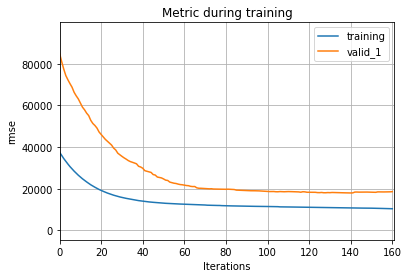

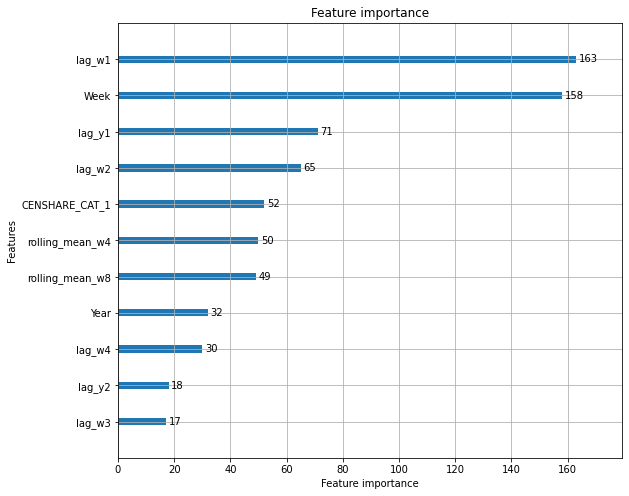

In [17]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

In [18]:
x_test

,Week,Year,CENSHARE_CAT_1,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
4686,46,5,0,76143.468750,74731.945312,79455.046875,77655.179688,78557.726562,68905.929688,48288.769531,41996.261719
4687,46,5,1,49.224998,73.837502,17.900000,17.900000,53.699997,107.400002,98.979996,206.380005
4688,46,5,2,119994.710938,125226.242188,124883.359375,111193.757812,129863.796875,114037.921875,79152.039062,113948.937500
4689,46,5,3,21295.003906,17025.060547,17006.529297,20494.150391,26364.949219,21314.390625,747.410034,385.200012
4690,46,5,4,20832.732422,20609.226562,22387.919922,18968.660156,24958.820312,17015.529297,14399.530273,10336.879883
4691,46,5,5,0.000000,12.450000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4692,46,5,6,17817.902344,17214.388672,19443.710938,20693.910156,16585.291016,14548.700195,14519.550781,9771.919922
4693,46,5,7,285.000000,188.750000,0.000000,740.000000,400.000000,0.000000,560.000000,0.000000
4694,46,5,8,273.320007,259.472504,418.359985,144.020004,249.600006,281.299988,297.309998,317.420013
4695,46,5,9,202388.312500,184857.812500,227819.562500,211971.093750,211052.203125,158710.406250,190622.859375,162992.250000


In [19]:
# Gather results of this article category and store them in general result_df
results_df = x_test[['Week', 'Year', 'CENSHARE_CAT_1']].copy()
results_df[target_variable] = list(y_test)
results_df['Prediction'] = list(y_pred)
results_df

,Week,Year,CENSHARE_CAT_1,Turnover,Prediction
4686,46,5,0,82315.570312,76435.735898
4687,46,5,1,89.500000,163.952029
4688,46,5,2,109553.679688,112795.520505
4689,46,5,3,18353.869141,17709.033553
4690,46,5,4,32968.609375,23178.425637
4691,46,5,5,24.900000,134.545512
4692,46,5,6,20785.519531,20229.587239
4693,46,5,7,560.000000,302.931839
4694,46,5,8,632.859985,326.039594
4695,46,5,9,293712.656250,243762.864075


In [20]:
mean_squared_error(results_df.Turnover, results_df.Prediction, squared=False)

17987.187704709373

## Forecast (Naive)

In [21]:
forecasts_naive = list(df_aggregated.loc[df_aggregated.Year == (Week(year, week))[0]].loc[df_aggregated.Week == (Week(year, week))[1]][target_variable])

In [22]:
mean_squared_error(results_df.Turnover, forecasts_naive, squared=False)

20291.239227447662

Forecasts with LightGBM are more accurate then forecasts computed with the naive approach